In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import glob
import pandas as pd
from collections import OrderedDict

In [2]:
#directories = glob.glob('.experiments/end-effector_tuning/*/*num_hiddens-2*/result*.pth')
#directories = glob.glob('.experiments/end-effector_tune_beta/*/*/result*.pth')
directories = glob.glob('.experiments/multi-point_beta_tuning/*/*/result*.pth')
#load each 
results = {}
seed = 0
is_one_model = False
for pth in directories:
    act = pth.split('/')[-2].split('-activation-')[-1].split('-')[0]
    hid_lay = pth.split('/')[-2].split('-num_hiddens-')[-1].split('-')[0]

    #algorithm = pth.split('/')[2] + '-' + dt
    #algorithm = act + '-' + hid_lay
    algorithm = pth.split('/')[-2].split('-beta-')[-1].split('-')[0]
    result = torch.load(pth)
    if algorithm in results and not is_one_model:
        start = len(results[algorithm])
        end = len(results[algorithm]) + len(result)
        j = 0
        for i in range(start, end):
            results[algorithm][i] = result[j]
            j += 1        
    elif algorithm in results and is_one_model:
        results[algorithm + "-" + str(seed)] = result
        seed += 1
    else:
        results[algorithm] = result
    
    

In [3]:
results.keys()

dict_keys(['0.05', '0.4', '0.8', '0.1', '0.2', '0.0', '1.6', '1.0'])

In [4]:
labels = [0.0, 0.05, 0.1, .2, .4, .8, 1.0, 1.6]
labels = [str(i) for i in labels]
#labels = OrderedDict(labels)
new_results = []
for label in labels:
    for k in results.keys():
        if label in k:
            print(k, label)
            new_results.append([label, results[k]])
            
results = new_results

results = OrderedDict(new_results)



0.05 0.0
0.0 0.0
0.05 0.05
0.1 0.1
0.2 0.2
0.4 0.4
0.8 0.8
1.0 1.0
1.6 1.6


In [5]:
results.keys()

odict_keys(['0.0', '0.05', '0.1', '0.2', '0.4', '0.8', '1.0', '1.6'])

# Plot Error Curves
In this section we want to see if our Jacobian estimates with our neural network actually solve the undlerying task of interest (i.e. moving the end effector to some target position)

In [6]:
def collect_eps_errs(result, dim=-1):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            state = v[5] #should be....state
            if dim < 0:
                psn = state[0:12]
                targ = state[-12:]
                mse = np.linalg.norm(targ - psn, 2)
                rmse = np.sqrt(mse)
                
                #mse = rmse
            else:
                psn = state[dim]
                targ = state[-3 + dim]
                mse = np.sqrt((targ - psn) ** 2)
            episode_err.append(mse)
        err_over_time.append(episode_err)
    return np.array(err_over_time).T

def plot_mu_sig(data, label=None, axis=1, ax=None,line_stype='b-'):
    samples = np.array(data)
    mean = samples.mean(axis=axis)
    std = samples.std(axis=axis)
    ste = std / np.sqrt(samples.shape[0]) #this is a hack, if axis not == 1, this will break
    
    if ax is None:
        plt.plot(mean, line_stype, label=label)
        plt.fill_between(list(range(mean.shape[0])), mean + std, mean - std, alpha=0.1)
    else:
        ax.plot(mean,line_stype, label=label)
        #ax.errorbar(list(range(mean.shape[0])), mean, yerr=std /np.sqrt(samples.shape[0]) , label=label)
        ax.fill_between(list(range(mean.shape[0])), mean + ste, mean - ste, color=line_stype[0], alpha=0.1)

In [7]:
err_curr_res = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time

In [8]:
line_types = [
            ("0.0", "b^"),
            ("0.05", "b|-"),
            ("0.1", "r-d"),
          ("0.2", "c-."),
         ("0.4", "g--"),
          ("0.8", "m-"),
          ("1.0", "y:"),
          ("1.6", "k--")
         ]
line_types = OrderedDict(line_types)

line_types.keys()

odict_keys(['0.0', '0.05', '0.1', '0.2', '0.4', '0.8', '1.0', '1.6'])

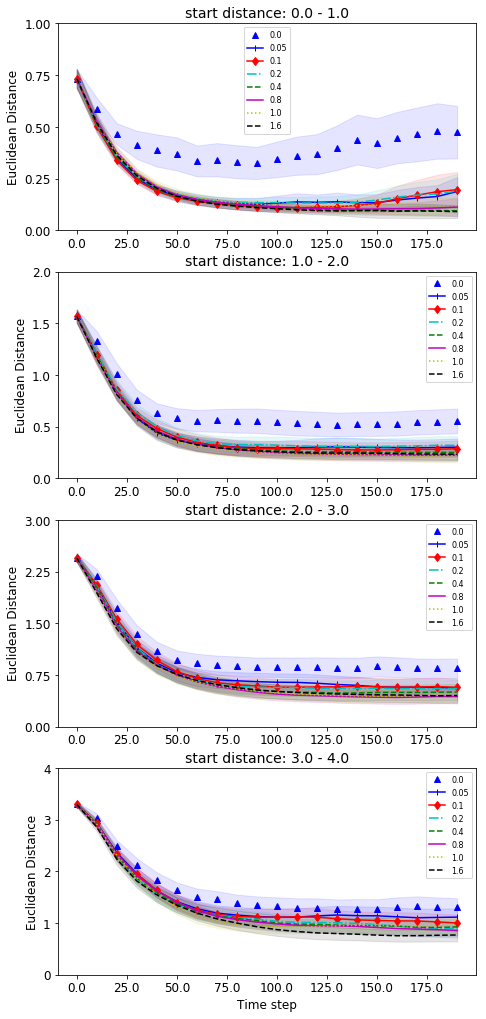

In [9]:
CONST = 1
SMALL_SIZE = 10 * CONST
MEDIUM_SIZE = 12 * CONST
BIGGER_SIZE = 16 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE + 2)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE - 2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    
bounds = [0.0, 1.0, 2.0, 3.0, 4.0]
n_plts = len(bounds) - 1
fig, axs = plt.subplots(4, 1, figsize=(7.5, 17.5))
axs = np.ndarray.flatten(axs)
i = 0
for start, end in zip(bounds[:-1], bounds[1:]):
    ax = axs[i]
    for algorithm in results.keys():
        err_over_time = err_curr_res[algorithm]
        to_plot = np.logical_and(err_over_time[0, :] >= start, err_over_time[0, :] < end)
        line_type = line_types[algorithm]
        plot_mu_sig(err_over_time[0:200:10, to_plot], label=algorithm, ax=ax, line_stype=line_type)
    
    
    ax.get_yaxis().set_ticks(np.linspace(0.0, end, 5))
    ax.legend()
    ax.set_title("start distance: {} - {}".format(start, end))
    
    
    ax.set_ylabel("Euclidean Distance")
    i += 1
    if i == len(bounds) - 1:
        ax.set_xlabel("Time step")

    ax.set_xticklabels(labels = 10* np.arange(-2.5, 20, 2.5))
        
    
plt.savefig('tuning_beta_error_curves.pdf',bbox_inches = 'tight',
    pad_inches = 0.1) 

# Visualising start and end points for Trajectories

In this section we visualize the starting position against the end position. The intention of these plots is to understand how distance to the target might affect convergence

# Violin Plots of End Performance

In this section we focus on the performance at the end of each episode. specifically whether or not the target was reached

In [11]:

violin_results = []
for algorithm, result in results.items():
    print(algorithm)
    err_over_time = collect_eps_errs(result, dim=-1)
    violin_results.append([algorithm, err_over_time])
    
violin_results = OrderedDict(violin_results)

0.0
0.05
0.1
0.2
0.4
0.8
1.0
1.6


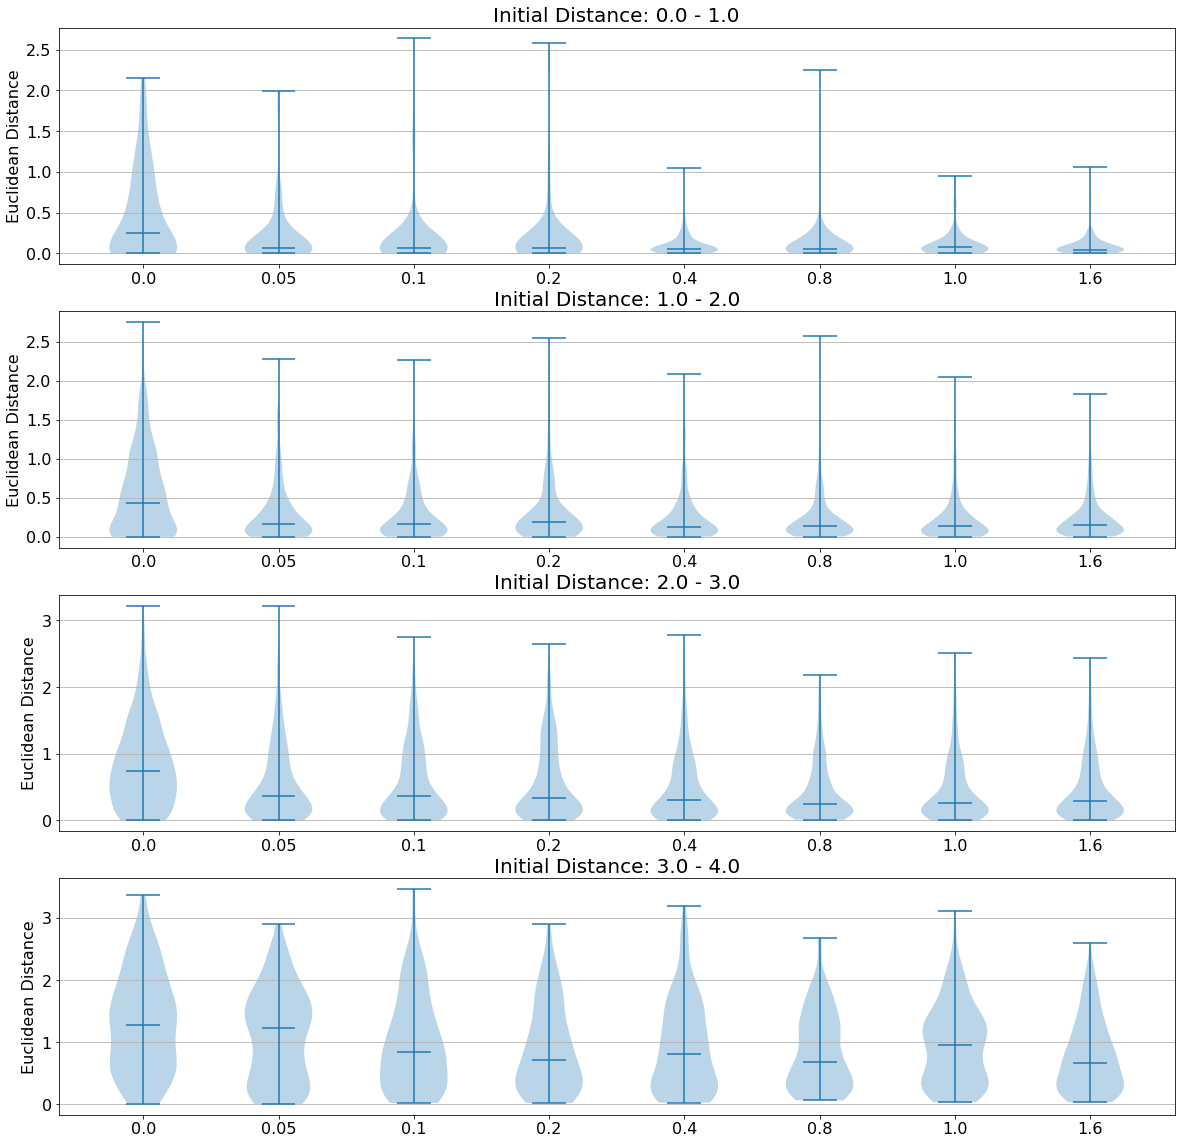

In [12]:
CONST = 1
SMALL_SIZE = 14 * CONST
MEDIUM_SIZE = 16 * CONST
BIGGER_SIZE = 20 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fig, axs = plt.subplots(4, 1, figsize=(20, 20))


bounds = [0.0, 1.0, 2.0, 3.0, 4.0]
successTable = {}
i = 0
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    end_dists = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        count.append(to_plot.sum())
        
        
        percentage = to_plot.sum() / count[-1]
        end_dist = err_over_time[-1, to_plot]  # for delta t between each timestep
        #end_dist = end_dist[to_plot]
        
        
        end_dists.append(end_dist)
        labels.append(algorithm)
    ax = axs[i]
    i+= 1
    ax.violinplot(end_dists, showmeans=False, showmedians=True)
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels([l.format(len(a)) for l, a in zip(labels, end_dists)])
    ax.yaxis.grid(True)
    ax.set_ylabel("Euclidean Distance")
    ax.set_title("Initial Distance: {} - {}".format(low, high))

plt.savefig('tuning_beta_violion_end_position.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)   

# These are just tables of statistics from the trajectories 
The basic question is whether or not they reached the target. 
We considered the target reached by some threshold


In [13]:
err_curr_res = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_timesuccessTable = {}

In [14]:

    
thresh = 0.05
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        count.append(to_plot.sum())
        
        to_plot = np.logical_and(to_plot, err_over_time[-1,:] <= thresh)
        CONST = 1

        percentage = to_plot.sum() / count[-1] * 100.0 #so it's between 0 - 100%
        algorithm = algorithm.split('-results')[0]
        
        if not algorithm in successTable:
            successTable[algorithm] = {"{}m - {}m".format(low,high): percentage}
        else:
            successTable[algorithm]["{}m - {}m".format(low,high)] = percentage

        labels.append(algorithm)
    
for algorithm, result in violin_results.items():
    err_over_time = result
    succeses = (err_over_time[-1,:] <= thresh)
    percentage = succeses.sum() / err_over_time.shape[1] * 100.0 #so it's between 0 - 100%
    algorithm = algorithm.split('-results')[0]
    if "global-" in algorithm:
        algorithm = algorithm.split('global-')[-1]
    if not algorithm in successTable:
            successTable[algorithm] = {"Overall": percentage}
    else:
        successTable[algorithm]["Overall"] = percentage
    
successTable = pd.DataFrame.from_dict(successTable).round(2).transpose()
successTable

,0.0m - 1.0m,1.0m - 2.0m,2.0m - 3.0m,3.0m - 4.0m,Overall
0.0,38.54,23.92,9.91,0.68,16.18
0.05,46.88,27.99,14.66,4.08,20.82
0.1,47.92,25.70,13.15,2.04,19.18
0.2,44.79,21.37,11.21,3.40,16.73
0.4,44.79,24.17,12.93,2.72,18.36
0.8,46.88,22.65,10.13,0.00,16.45
1.0,43.75,26.97,11.21,0.68,18.27
1.6,53.12,20.10,9.48,1.36,16.00


['0.0m - 1.0m', '1.0m - 2.0m', '2.0m - 3.0m', '3.0m - 4.0m', 'Overall']
[38.54, 23.92, 9.91, 0.68, 16.18]
[46.88, 27.99, 14.66, 4.08, 20.82]
[47.92, 25.7, 13.15, 2.04, 19.18]
[44.79, 21.37, 11.21, 3.4, 16.73]
[44.79, 24.17, 12.93, 2.72, 18.36]
[46.88, 22.65, 10.13, 0.0, 16.45]
[43.75, 26.97, 11.21, 0.68, 18.27]
[53.12, 20.1, 9.48, 1.36, 16.0]
['0.0m - 1.0m', '1.0m - 2.0m', '2.0m - 3.0m', '3.0m - 4.0m', 'Overall']


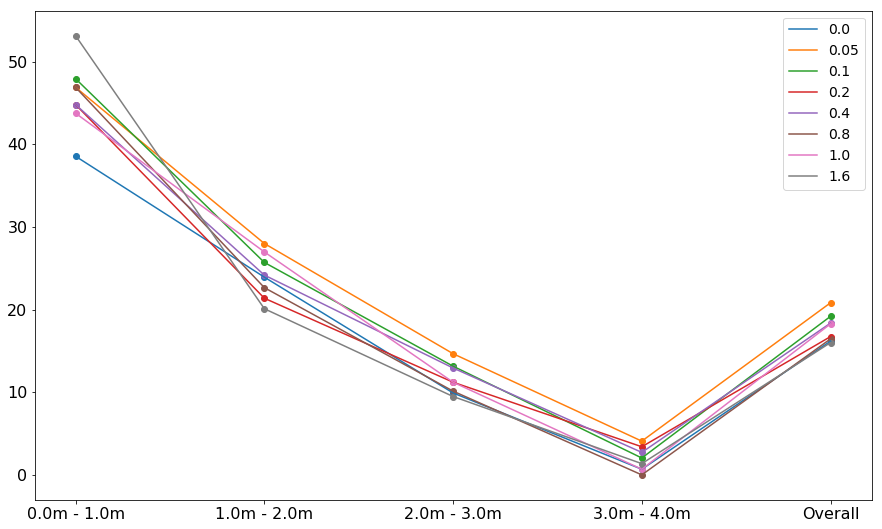

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
cols = successTable.columns.values
rows = successTable.index.values
print(cols.tolist())
for r in rows:
    row = successTable.loc[r].tolist()
    print(row)
    ax.plot(row, label =r)
    ax.scatter(np.arange(len(row)), row)
ax.legend()
ax.set_xticks(np.arange(len(row)))
ax.set_xticklabels(cols.tolist())
print(cols.tolist())

In [16]:
end_dist_table = {}
end_dist_table_std = {}
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        end_diff = err_over_time[-1,:]
        end_diff = end_diff[to_plot]
        
        
        mu = end_diff.mean()
        std = end_diff.std() / np.sqrt(np.sum(to_plot))
        algorithm = algorithm.split('-results')[0]
        if "global-" in algorithm:
            algorithm = algorithm.split('global-')[-1]
        
        if not algorithm in end_dist_table:
            end_dist_table[algorithm] = {"{}m - {}m".format(low,high): mu}
            end_dist_table_std[algorithm] = {"{}m - {}m".format(low,high): std}
        else:
            end_dist_table[algorithm]["{}m - {}m".format(low,high)] = mu
            end_dist_table_std[algorithm]["{}m - {}m".format(low,high)] = std
            
        if "global-neuralnetwork" in algorithm:
            labels.append(algorithm.split("global-")[-1])
        else:
            labels.append(algorithm)
    
for algorithm, result in violin_results.items():
    err_over_time = result
    end_diff = err_over_time[-1,:]
    mu = end_diff.mean()
    std = end_diff.std()  / np.sqrt(np.sum(to_plot)) #ste
    
    algorithm = algorithm.split('-results')[0]
    if "global-" in algorithm:
        algorithm = algorithm.split('global-')[-1]
    if not algorithm in end_dist_table:
            end_dist_table[algorithm] = {"Overall": mu}
            end_dist_table_std[algorithm] = {"Overall".format(low,high): std}
    else:
        end_dist_table[algorithm]["Overall"] = mu
        end_dist_table_std[algorithm]["Overall"] = std
        
    
end_dist_table = pd.DataFrame.from_dict(end_dist_table).round(3).transpose()
end_dist_table_std = pd.DataFrame.from_dict(end_dist_table_std).round(3).transpose()
end_dist_table

,0.0m - 1.0m,1.0m - 2.0m,2.0m - 3.0m,3.0m - 4.0m,Overall
0.0,0.474,0.561,0.847,1.311,0.774
0.05,0.213,0.304,0.561,1.103,0.511
0.1,0.206,0.289,0.563,0.998,0.492
0.2,0.198,0.321,0.559,0.901,0.488
0.4,0.098,0.253,0.497,0.935,0.433
0.8,0.118,0.227,0.432,0.852,0.387
1.0,0.124,0.224,0.450,0.965,0.410
1.6,0.089,0.234,0.457,0.776,0.388


['0.0m - 1.0m', '1.0m - 2.0m', '2.0m - 3.0m', '3.0m - 4.0m', 'Overall']
['0.0m - 1.0m', '1.0m - 2.0m', '2.0m - 3.0m', '3.0m - 4.0m', 'Overall']


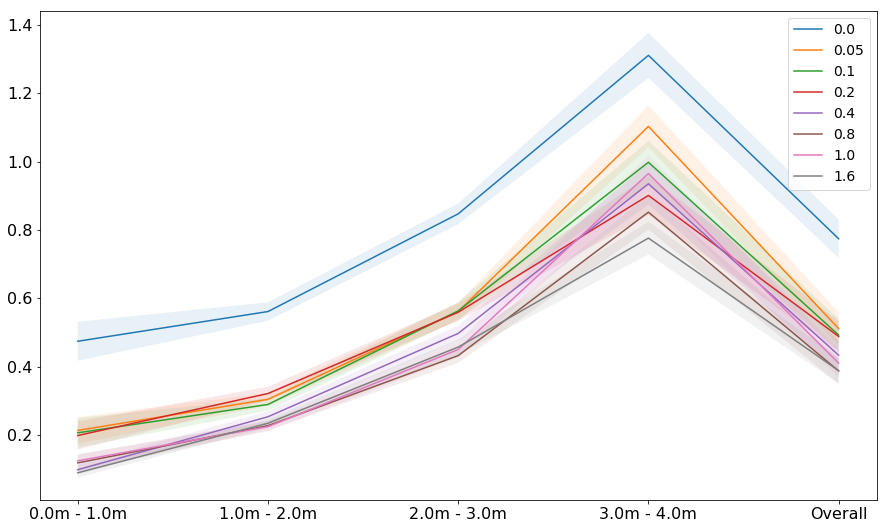

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
cols = end_dist_table.columns.values
rows = end_dist_table.index.values
print(cols.tolist())
for r in rows:
    row = np.array(end_dist_table.loc[r].tolist())
    std = np.array(end_dist_table_std.loc[r].tolist())
    ax.plot(row, label = r)
    ax.fill_between(list(range(len(row))), row + std, row - std, alpha=0.1)
ax.legend()
ax.set_xticks(np.arange(len(row)))
ax.set_xticklabels(cols.tolist())
print(cols.tolist())

# Comparing Jacobians

Here, we just calaculate the difference between Jacobians in trajectories to see how much they differ from the true underlying Jacobian

In [18]:
def collect_jacobian_dist(result, norm=None):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            estimate_J = v[-2] 

            true_J = v[-1]
            if norm is not "signs":
                mse = np.linalg.norm(estimate_J - true_J, norm) #, 'fro')
            else:
                sign_mismatch = np.logical_not(np.logical_and(estimate_J, true_J))
                mse = (sign_mismatch).sum() #techinically not mind you...
            episode_err.append(mse)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T

In [19]:
line_types = [
            ("0.0", "b^"),
            ("0.05", "b|-"),
            ("0.1", "r-d"),
          ("0.2", "c-."),
         ("0.4", "g--"),
          ("0.8", "m-"),
          ("1.0", "y:"),
          ("1.6", "k--")
         ]
line_types = OrderedDict(line_types)

line_types.keys()

odict_keys(['0.0', '0.05', '0.1', '0.2', '0.4', '0.8', '1.0', '1.6'])

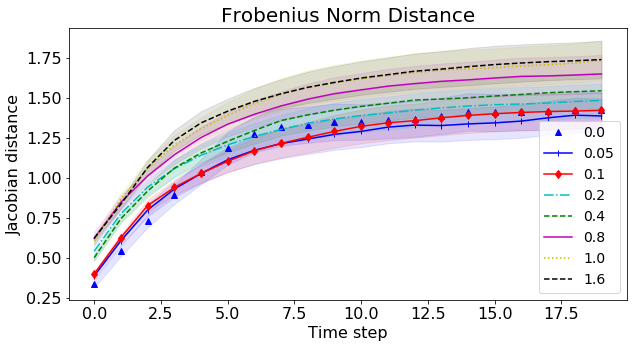

In [20]:
CONST = 1
SMALL_SIZE = 14 * CONST
MEDIUM_SIZE = 16 * CONST
BIGGER_SIZE = 20 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#Focusing only on the frobenius norm
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for algorithm, result in results.items():
    jac_err = collect_jacobian_dist(result)
    line_type = line_types[algorithm]
    plot_mu_sig(jac_err[0:200:10, :], label=algorithm, ax=ax, line_stype=line_type)

    
ax.set_xlabel('Time step')
ax.set_ylabel('Jacobian distance')
ax.set_title("Frobenius Norm Distance")
ax.legend()
plt.savefig('tuning_beta_jacobian_diff_global.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)   

In [25]:
#collects results for plotting histograms and trajectories
err_curr_res = {}
jac_errs = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time
    jac_err = collect_jacobian_dist(result)
    jac_errs[algorithm] = jac_err

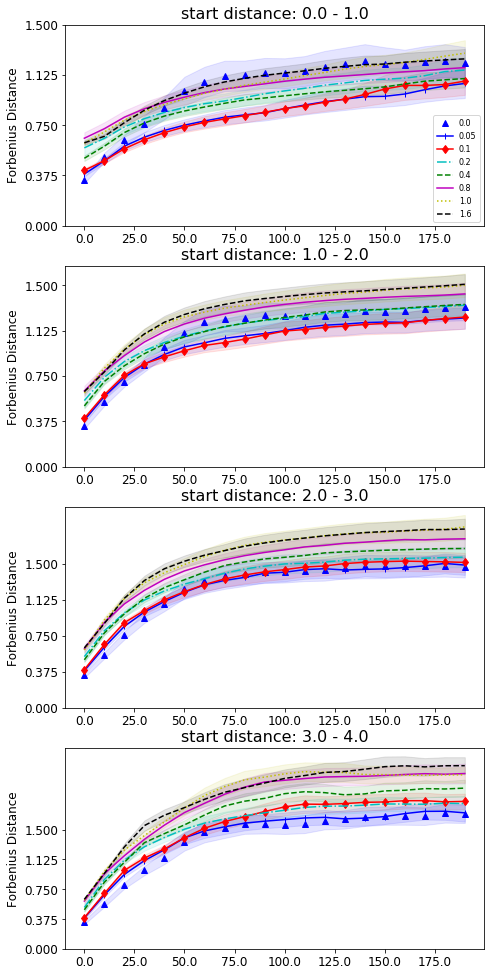

In [30]:
CONST = 1
SMALL_SIZE = 10 * CONST
MEDIUM_SIZE = 12 * CONST
BIGGER_SIZE = 16 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE - 2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bounds = [0.0, 1.0, 2.0, 3.0, 4.0]
fig, axs = plt.subplots(4, 1, figsize=(7.5, 17))
axs = np.ndarray.flatten(axs)
i = 0
for start, end in zip(bounds[:-1], bounds[1:]):
    ax = axs[i]
    for algorithm in results.keys():
        err_over_time = err_curr_res[algorithm]
        to_plot = np.logical_and(err_over_time[0, :] >= start, err_over_time[0, :] < end)
        line_type = line_types[algorithm]
    
        plot_mu_sig(jac_errs[algorithm][0:200:10,to_plot], label=algorithm, ax=ax, line_stype=line_type)
        
    
    
    ax.get_yaxis().set_ticks(np.linspace(0.0, 1.5, 5))
    if i == 0:
        ax.legend()
    ax.set_title("start distance: {} - {}".format(start, end))
    
    #    ax.get_xaxis().set_ticks([])
    if i == 4:
        ax.set_xlabel("Time step")
    
    ax.set_ylabel("Forbenius Distance")
    ax.set_xticklabels(labels = 10* np.arange(-2.5, 20, 2.5))
    i += 1
    
plt.savefig('tuning_beta_jacobian_diff_by_dist.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)   

# Histograms of Jacobian difference
The previous plots were for trends over trajectories. The Jacobian differences are really independent of timesteps so to get a sense of these differences we visualize the results with histograms 


In [28]:
err_curr_res = {}
jac_errs = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time
    jac_err = collect_jacobian_dist(result)
    jac_errs[algorithm] = jac_err

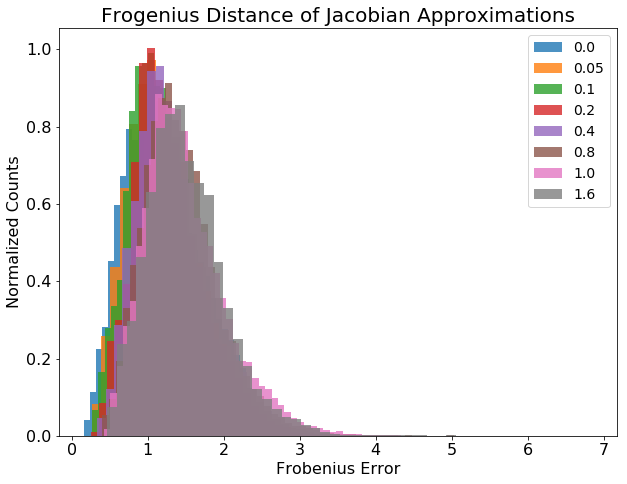

In [29]:
CONST = 1
SMALL_SIZE = 14 * CONST
MEDIUM_SIZE = 16 * CONST
BIGGER_SIZE = 20 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Focusing only on the frobenius norm
fig, ax = plt.subplots(1, 1, figsize=(10, 7.5))

for algorithm, result in results.items():
    if "Inverse" in algorithm:
        continue
    #jac_err = collect_jacobian_dist(result)
    jac_err = jac_errs[algorithm]
    jac_err = jac_err.flatten()

    ax.hist(jac_err, bins=50, alpha=0.8, density=True, label=algorithm)
    
ax.set_xlabel('Frobenius Error')
ax.set_ylabel('Normalized Counts')
ax.set_title("Frogenius Distance of Jacobian Approximations")
ax.legend()

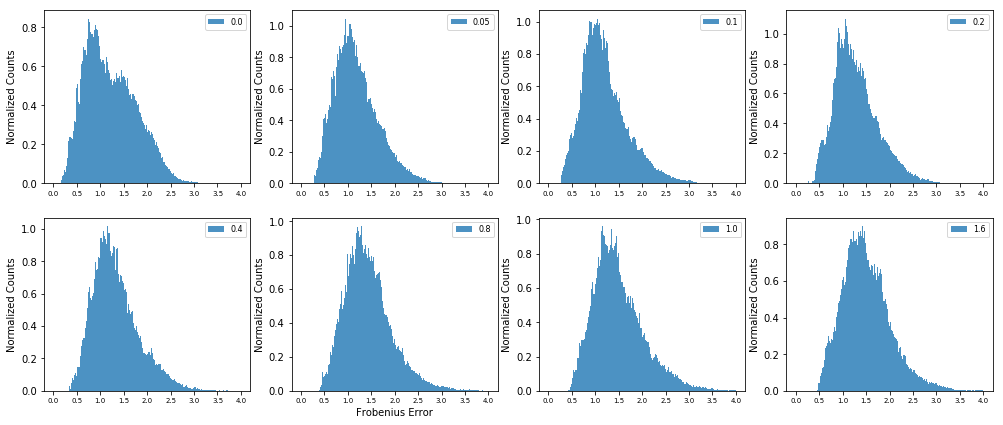

In [27]:
CONST = 1
SMALL_SIZE = 8 * CONST
MEDIUM_SIZE = 10 * CONST
BIGGER_SIZE = 14 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE - 1)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE -1)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Focusing only on the frobenius norm
fig, axs = plt.subplots(2, 4, figsize=(17, 7))
axs = np.ndarray.flatten(axs)
i = 0
for algorithm, result in results.items():
    if "Inverse" in algorithm:
        continue
    ax = axs[i]
    i += 1
    jac_err = jac_err = jac_errs[algorithm]
    jac_err = jac_err.flatten()

    ax.hist(jac_err, bins=200, alpha=0.8, density=True, range=(0, 4), label=algorithm)
    #if i == 1:
    #    ax.set_title("F")
    ax.legend()
    #if i == 1 or i == 4:
    ax.set_ylabel('Normalized Counts')
    if i == 6:
        ax.set_xlabel("Frobenius Error")


plt.savefig('tuning_beta_jacobian_hist.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)  

# On the rank of our Jacobian
In these plots we're mostly interested in seeing whether or not our Jacobian's are full rank or not. 
We also consider the ratio of the maximum to minimum singular values of the jacobian to see if we are in singularity configurations

In [31]:
def check_jacobian_dexterity(result):
    #we use 3rd dexterity definition in : 
    #https://vtechworks.lib.vt.edu/bitstream/handle/10919/30363/Chap4.pdf?sequence=7&isAllowed=y
    #this is just ratio of largest to smallest singular values 
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            J_hat = v[-2] 
            J = v[-1]
            n, m = J_hat.shape
            smaller_dims = min(n, m)
            _, s, _ = np.linalg.svd(J_hat, full_matrices=False, compute_uv=True, hermitian=False)
            s = s[:smaller_dims] #to determine if full rank on smaller dimension...i.e. the rows for me
            loss = max(s) / min(s)
            #loss = np.all((s > 0)) #if all greater than 0 implies fu
            episode_err.append(loss)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T

def check_jacobian_rank(result):
    #we use 3rd dexterity definition in : 
    #https://vtechworks.lib.vt.edu/bitstream/handle/10919/30363/Chap4.pdf?sequence=7&isAllowed=y
    #this is just ratio of largest to smallest singular values 
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            J_hat = v[-2] 
            J = v[-1]
            n, m = J_hat.shape
            smaller_dims = min(n, m)
            _, s, _ = np.linalg.svd(J_hat, full_matrices=False, compute_uv=True, hermitian=False)
            s = s[:smaller_dims] #to determine if full rank on smaller dimension...i.e. the rows for me
            loss = np.all((s > 0.1)) #if all greater than 0.1 not super close to a singularity
            episode_err.append(loss)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T

In [32]:
singular_values = {} 
for algorithm, result in results.items():
    if "inverse" in algorithm:
        continue
    singular_val_ratio = check_jacobian_dexterity(result)
    singular_values[algorithm] = singular_val_ratio
    

In [33]:
singular_values.keys()

dict_keys(['0.05', '0.4', '0.8', '0.1', '0.2', '0.0', '1.6', '1.0'])

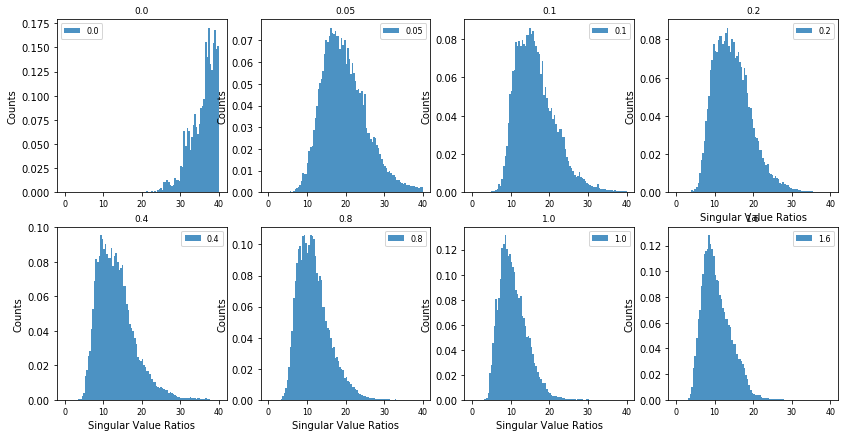

In [34]:
CONST = 1
SMALL_SIZE = 8 * CONST
MEDIUM_SIZE = 10 * CONST
BIGGER_SIZE = 14 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE - 1)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# look at the distribution of the singular value ratios for dexterity in workspace
fig, axs = plt.subplots(2, 4, figsize=(14, 7))
axs = np.ndarray.flatten(axs)
i = 0
for algorithm, result in results.items():
    if "Finite" in algorithm:
        continue
    ax = axs[i]
    i += 1
    singular_val_ratio = singular_values[algorithm]
    singular_val_ratio = singular_val_ratio.flatten()

    ax.hist(singular_val_ratio, bins=100, alpha=0.8, density=True, range=(0, 40), label=algorithm)
    
    ax.set_ylabel('Counts')
    ax.set_title(algorithm)
    ax.legend()
    if i == (len(results) - 1) or i == 4 or i == 6 or i == 5:
        ax.set_xlabel('Singular Value Ratios')

# Checking for Criteria of Convergence
The last thing I want to check for is for whether or not the critieria on J is met for the trajectories. I will need to review this to make sure I understand it, but if JJ^{+} has any non-positive eigen values (0 or less) then hypothetically, it should not converge.

I think hypothetically JJ^{+} should be the identity matrix...and if it's not then we have problems otherwise, I'll need to read up on that. 

In [35]:
def check_pos_definite(A):
    eigs = np.linalg.eigvals(A)
            
    return (eigs > 0).all()
    
def check_jacobian_positive_definite(result, invert_true_J=False):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            J_hat = v[-2] 
            J = v[-1]
            
            if invert_true_J:
                iJ_hat = np.linalg.pinv(J_hat)
                JiJ = np.matmul(J, iJ_hat)
            else:
                iJ = np.linalg.pinv(J)
                JiJ = np.matmul(J_hat, iJ)
            is_pos_def = check_pos_definite(JiJ)
            loss = int(is_pos_def)
            episode_err.append(loss)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T





In [36]:
jacobian_split = {}
for k, v in results.items():
    algorithm, result = k, v
    if "inverse" in algorithm:
        continue
        
    jac_err = check_jacobian_positive_definite(result)
    
    #check if criteria is met for whole trajectory or not
    always_pos_def = (jac_err.sum(axis=0) >=200)
    not_always_pos_def = (jac_err.sum(axis=0) < 200)
    
    total_traj = jac_err.shape[1]
    total_pos_d = always_pos_def.sum()
    total_not_pos_d = not_always_pos_def.sum()
    
    err_over_time = collect_eps_errs(result, dim=-1)
    traj_pos_def = err_over_time[:,always_pos_def]
    traj_not_pos_def = err_over_time[:, not_always_pos_def]
    
    jacobian_split[algorithm] = {"pos_def": traj_pos_def,
                                "not_pos_def": traj_not_pos_def,
                                 "pos_count": total_pos_d,
                                 "not_pos_count": total_not_pos_d,
                                 "total": total_traj
                                }
    

In [37]:
line_types = [
            ("0.00", "b^"),
            ("0.05", "b|-"),
            ("0.1", "r-d"),
          ("0.2", "c-."),
         ("0.4", "g--"),
          ("0.8", "m-"),
          ("1.0", "y:"),
          ("1.6", "k--")
         ]
line_types = OrderedDict(line_types)

line_types.keys()

odict_keys(['0.00', '0.05', '0.1', '0.2', '0.4', '0.8', '1.0', '1.6'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
/home/przystupa/.local/lib/python3.5/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/przystupa/.local/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/przystupa/.local/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/przystupa/.local/lib/python3.5/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


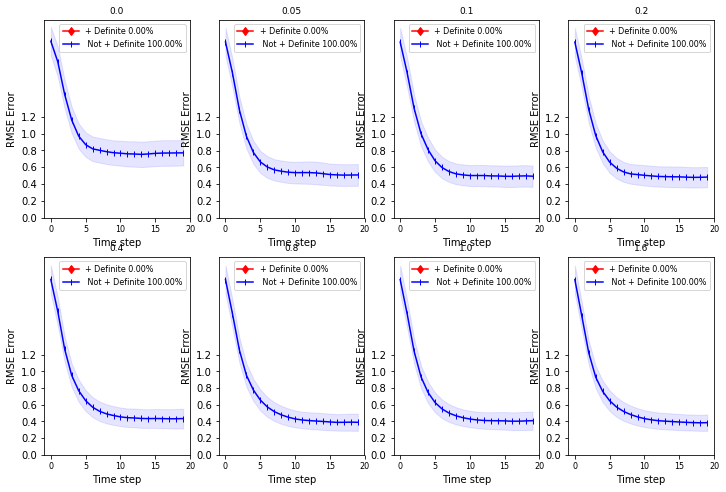

In [38]:
CONST = 1
SMALL_SIZE = 8 * CONST
MEDIUM_SIZE = 10 * CONST
BIGGER_SIZE = 14 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE - 1)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#Focusing only on the frobenius norm
fig, axs = plt.subplots(2 , 4, figsize=(12, 8))
axs = np.ndarray.flatten(axs)
#if not isinstance(axs, list):
#    axs = [axs]
i = 0
for k, v in results.items():
    algorithm, result = k, v
    if "Inverse" in algorithm:
        continue
    ax = axs[i]
    i += 1

    traj_pos_def = jacobian_split[algorithm]["pos_def"]
    traj_not_pos_def = jacobian_split[algorithm]["not_pos_def"]
    total_pos_d = jacobian_split[algorithm]["pos_count"]
    total_not_pos_d = jacobian_split[algorithm]["not_pos_count"]
    total_traj =  jacobian_split[algorithm]["total"]
    #plot_mu_sig(err_over_time, label="All {} Trajectories".format(total_traj), ax=ax)
    plot_mu_sig(traj_pos_def[0:200:10], label="+ Definite {:.2f}%".format(round(total_pos_d / total_traj, 2) *100.0), ax=ax, line_stype="r-d")
    plot_mu_sig(traj_not_pos_def[0:200:10], label=" Not + Definite {:.2f}%".format(round(total_not_pos_d / total_traj, 2) *100.0), ax=ax, line_stype="b|-")
    #if i >= len(axs) - 1:
    ax.set_xlabel('Time step')
    #else:
    #    ax.get_xaxis().set_ticks([])
    ax.set_yticks(np.arange(0, 1.4, 0.2))
    ax.set_ylabel('RMSE Error')
    ax.set_title("{}".format(algorithm))
    ax.legend()
    
plt.savefig('tuning_beta_separate_by_pos_def.pdf',bbox_inches = 'tight',
    pad_inches = 0.1) 